### Testing out the new project

In [51]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np

from src.clean import detect_na, standardize_columns, impute_nas
from src.eda import extended_describe, plot_correlation_heatmap, plot_dists, calc_vif, lasso_feat_select, elastic_feat_select, feat_select
from src.train import train_model
from src.tune import grid_search
from src.eval import eval_classification
from src.predict import load_trained_model, make_preds

# df = pd.read_csv('../data/Breast_Cancer.csv')
df = pd.read_csv('../data/heart_attack_china.csv')

df

,Patient_ID,Age,Gender,Smoking_Status,Hypertension,Diabetes,Obesity,Cholesterol_Level,Air_Pollution_Exposure,Physical_Activity,...,Hospital_Availability,TCM_Use,Employment_Status,Education_Level,Income_Level,Blood_Pressure,Chronic_Kidney_Disease,Previous_Heart_Attack,CVD_Risk_Score,Heart_Attack
0,1,55,Male,Non-Smoker,No,No,Yes,Normal,High,High,...,Low,Yes,Unemployed,Primary,Low,104,Yes,No,78,No
1,2,66,Female,Smoker,Yes,No,No,Low,Medium,High,...,High,No,Unemployed,Secondary,Middle,142,No,No,49,No
2,3,69,Female,Smoker,No,No,No,Low,Medium,High,...,Low,No,Unemployed,Primary,High,176,No,No,31,No
3,4,45,Female,Smoker,No,Yes,No,Normal,Medium,Low,...,Medium,Yes,Employed,Primary,Low,178,No,Yes,23,No
4,5,39,Female,Smoker,No,No,No,Normal,Medium,Medium,...,Low,No,Retired,Higher,Middle,146,Yes,No,79,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239261,239262,53,Male,Non-Smoker,No,No,No,Normal,Medium,Medium,...,High,Yes,Retired,Higher,Low,167,No,No,86,Yes
239262,239263,48,Female,Non-Smoker,No,No,Yes,Normal,Low,Medium,...,Medium,Yes,Unemployed,Higher,Low,179,No,No,25,No
239263,239264,57,Male,Smoker,Yes,No,No,Normal,Low,High,...,Medium,Yes,Retired,Higher,Middle,136,No,No,89,No
239264,239265,42,Female,Non-Smoker,No,No,No,High,Medium,High,...,Low,Yes,Employed,Primary,Middle,159,No,No,72,Yes


### Cleaning and Preprocessing

In [52]:
detect_na(df)

,Columns,NA_count
0,Patient_ID,0
1,Age,0
2,Gender,0
3,Smoking_Status,0
4,Hypertension,0
5,Diabetes,0
6,Obesity,0
7,Cholesterol_Level,0
8,Air_Pollution_Exposure,0
9,Physical_Activity,0


Seems like it's mostly pristine, with one column, `Education_Level` needing to be removed.

In [53]:
df.drop(['Education_Level', 'Patient_ID'], axis='columns', inplace=True)


### EDA

In [54]:
# This will kick off a much larger discussion about that OHE (One Hot Encoding) and the drop_first=True argument
# It's undeniable that some information will be lost, but it can be re-created, no? 
# Yes, they can! It's tedious, but it can be done... then what's the harm? 
# Well, when there's hundreds or thousands of features, categorical reconstruction doesn't feel as feasible! 
# Exploring this concept more in a blog post; for now we'll just use get_dummies as usual

df_encoded = pd.get_dummies(df, dtype=int, drop_first=True)

df_encoded = standardize_columns(df_encoded)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239266 entries, 0 to 239265
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype
---  ------                         --------------   -----
 0   age                            239266 non-null  int64
 1   blood_pressure                 239266 non-null  int64
 2   cvd_risk_score                 239266 non-null  int64
 3   gender_male                    239266 non-null  int64
 4   smoking_status_smoker          239266 non-null  int64
 5   hypertension_yes               239266 non-null  int64
 6   diabetes_yes                   239266 non-null  int64
 7   obesity_yes                    239266 non-null  int64
 8   cholesterol_level_low          239266 non-null  int64
 9   cholesterol_level_normal       239266 non-null  int64
 10  air_pollution_exposure_low     239266 non-null  int64
 11  air_pollution_exposure_medium  239266 non-null  int64
 12  physical_activity_low          239266 non-null  int64
 13 

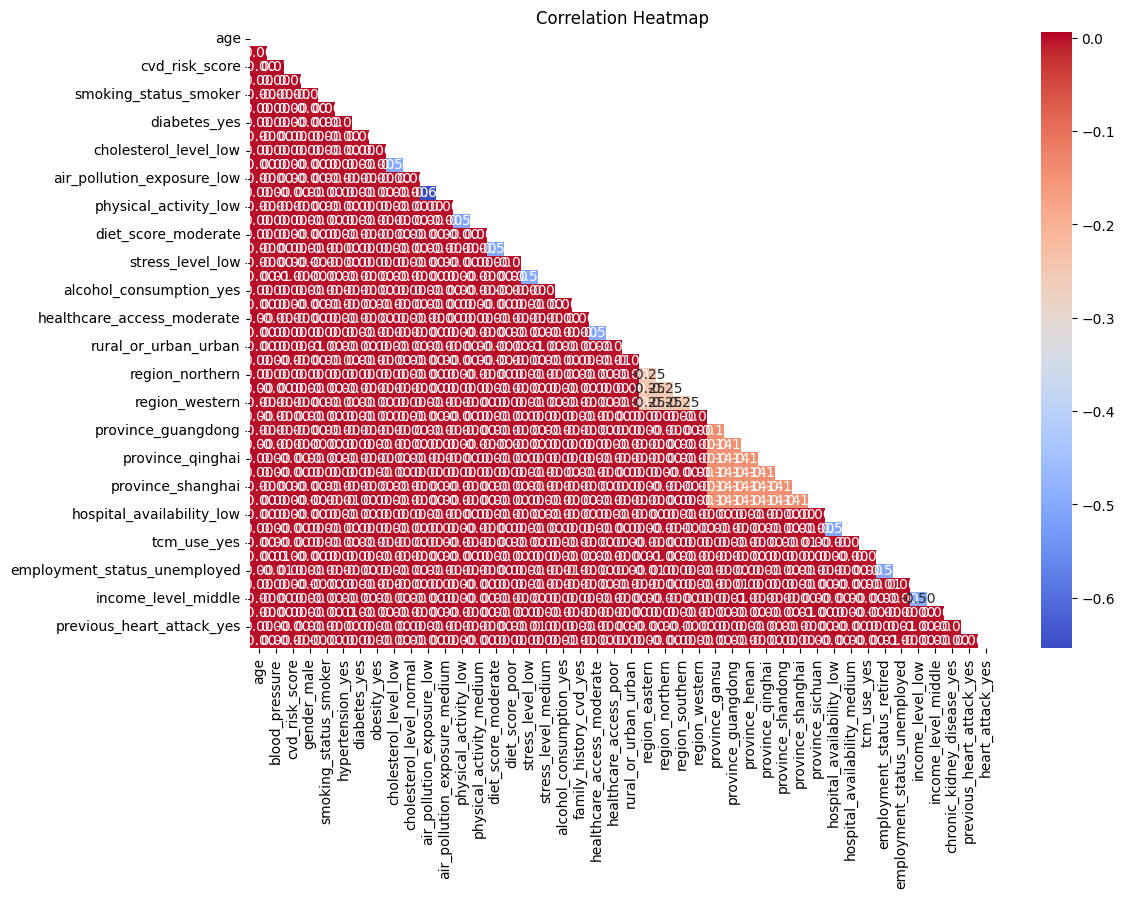

In [55]:
plot_correlation_heatmap(df_encoded)

Wow-- lots of features now, makes sense since we just performed OHE. However, there's way too much going on here, it needs to be cut down. I think for this task I'll use LASSO to perform automatic feature selection, with tumor_size as my target.

In [66]:
# Using tumor_size as target
# feat_select is now capable of lasso, ridge or e-net (method)

feat_select(df_encoded, target='heart_attack_yes', method='lasso')

Best alpha: 1.0

Feature Coefficients:
age                             -0.0
blood_pressure                   0.0
cvd_risk_score                  -0.0
gender_male                     -0.0
smoking_status_smoker           -0.0
hypertension_yes                 0.0
diabetes_yes                     0.0
obesity_yes                      0.0
cholesterol_level_low           -0.0
cholesterol_level_normal         0.0
air_pollution_exposure_low      -0.0
air_pollution_exposure_medium    0.0
physical_activity_low            0.0
physical_activity_medium        -0.0
diet_score_moderate              0.0
diet_score_poor                  0.0
stress_level_low                 0.0
stress_level_medium              0.0
alcohol_consumption_yes          0.0
family_history_cvd_yes          -0.0
healthcare_access_moderate      -0.0
healthcare_access_poor           0.0
rural_or_urban_urban             0.0
region_eastern                   0.0
region_northern                 -0.0
region_southern                  0.0

,heart_attack_yes
0,0
1,0
2,0
3,0
4,0
...,...
239261,1
239262,0
239263,0
239264,1


In [44]:
summary_stats = extended_describe(df_encoded) 
summary_stats

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
patient_id,239266.0,119633.500000,69070.289091,1.0,59817.25,119633.5,179449.75,239266.0,-6.234359e-16,-1.200000
age,239266.0,59.466284,17.348308,30.0,44.00,59.0,75.00,89.0,2.302139e-03,-1.204728
blood_pressure,239266.0,134.513378,25.991827,90.0,112.00,135.0,157.00,179.0,-1.079007e-03,-1.201560
cvd_risk_score,239266.0,54.485581,25.987743,10.0,32.00,54.0,77.00,99.0,3.694026e-04,-1.200624
gender_male,239266.0,0.498683,0.499999,0.0,0.00,0.0,1.00,1.0,5.266157e-03,-1.999989
smoking_status_smoker,239266.0,0.499733,0.500001,0.0,0.00,0.0,1.00,1.0,1.069946e-03,-2.000016
hypertension_yes,239266.0,0.270448,0.444192,0.0,0.00,0.0,1.00,1.0,1.033580e+00,-0.931721
diabetes_yes,239266.0,0.110638,0.313684,0.0,0.00,0.0,0.00,1.0,2.482526e+00,4.162970
obesity_yes,239266.0,0.299855,0.458195,0.0,0.00,0.0,1.00,1.0,8.736329e-01,-1.236776
cholesterol_level_low,239266.0,0.332496,0.471109,0.0,0.00,0.0,1.00,1.0,7.111113e-01,-1.494333


In [62]:
calc_vif(df_encoded)

,Feature,VIF
0,age,10.883211
1,blood_pressure,18.600503
2,cvd_risk_score,5.110326
3,gender_male,1.970655
4,smoking_status_smoker,1.974449
5,hypertension_yes,1.365352
6,diabetes_yes,1.123297
7,obesity_yes,1.420717
8,cholesterol_level_low,1.962615
9,cholesterol_level_normal,1.968878


Ah, seems like we've got some highly inflated features, namely `age` and `blood_pressure`! This calls for some investigation

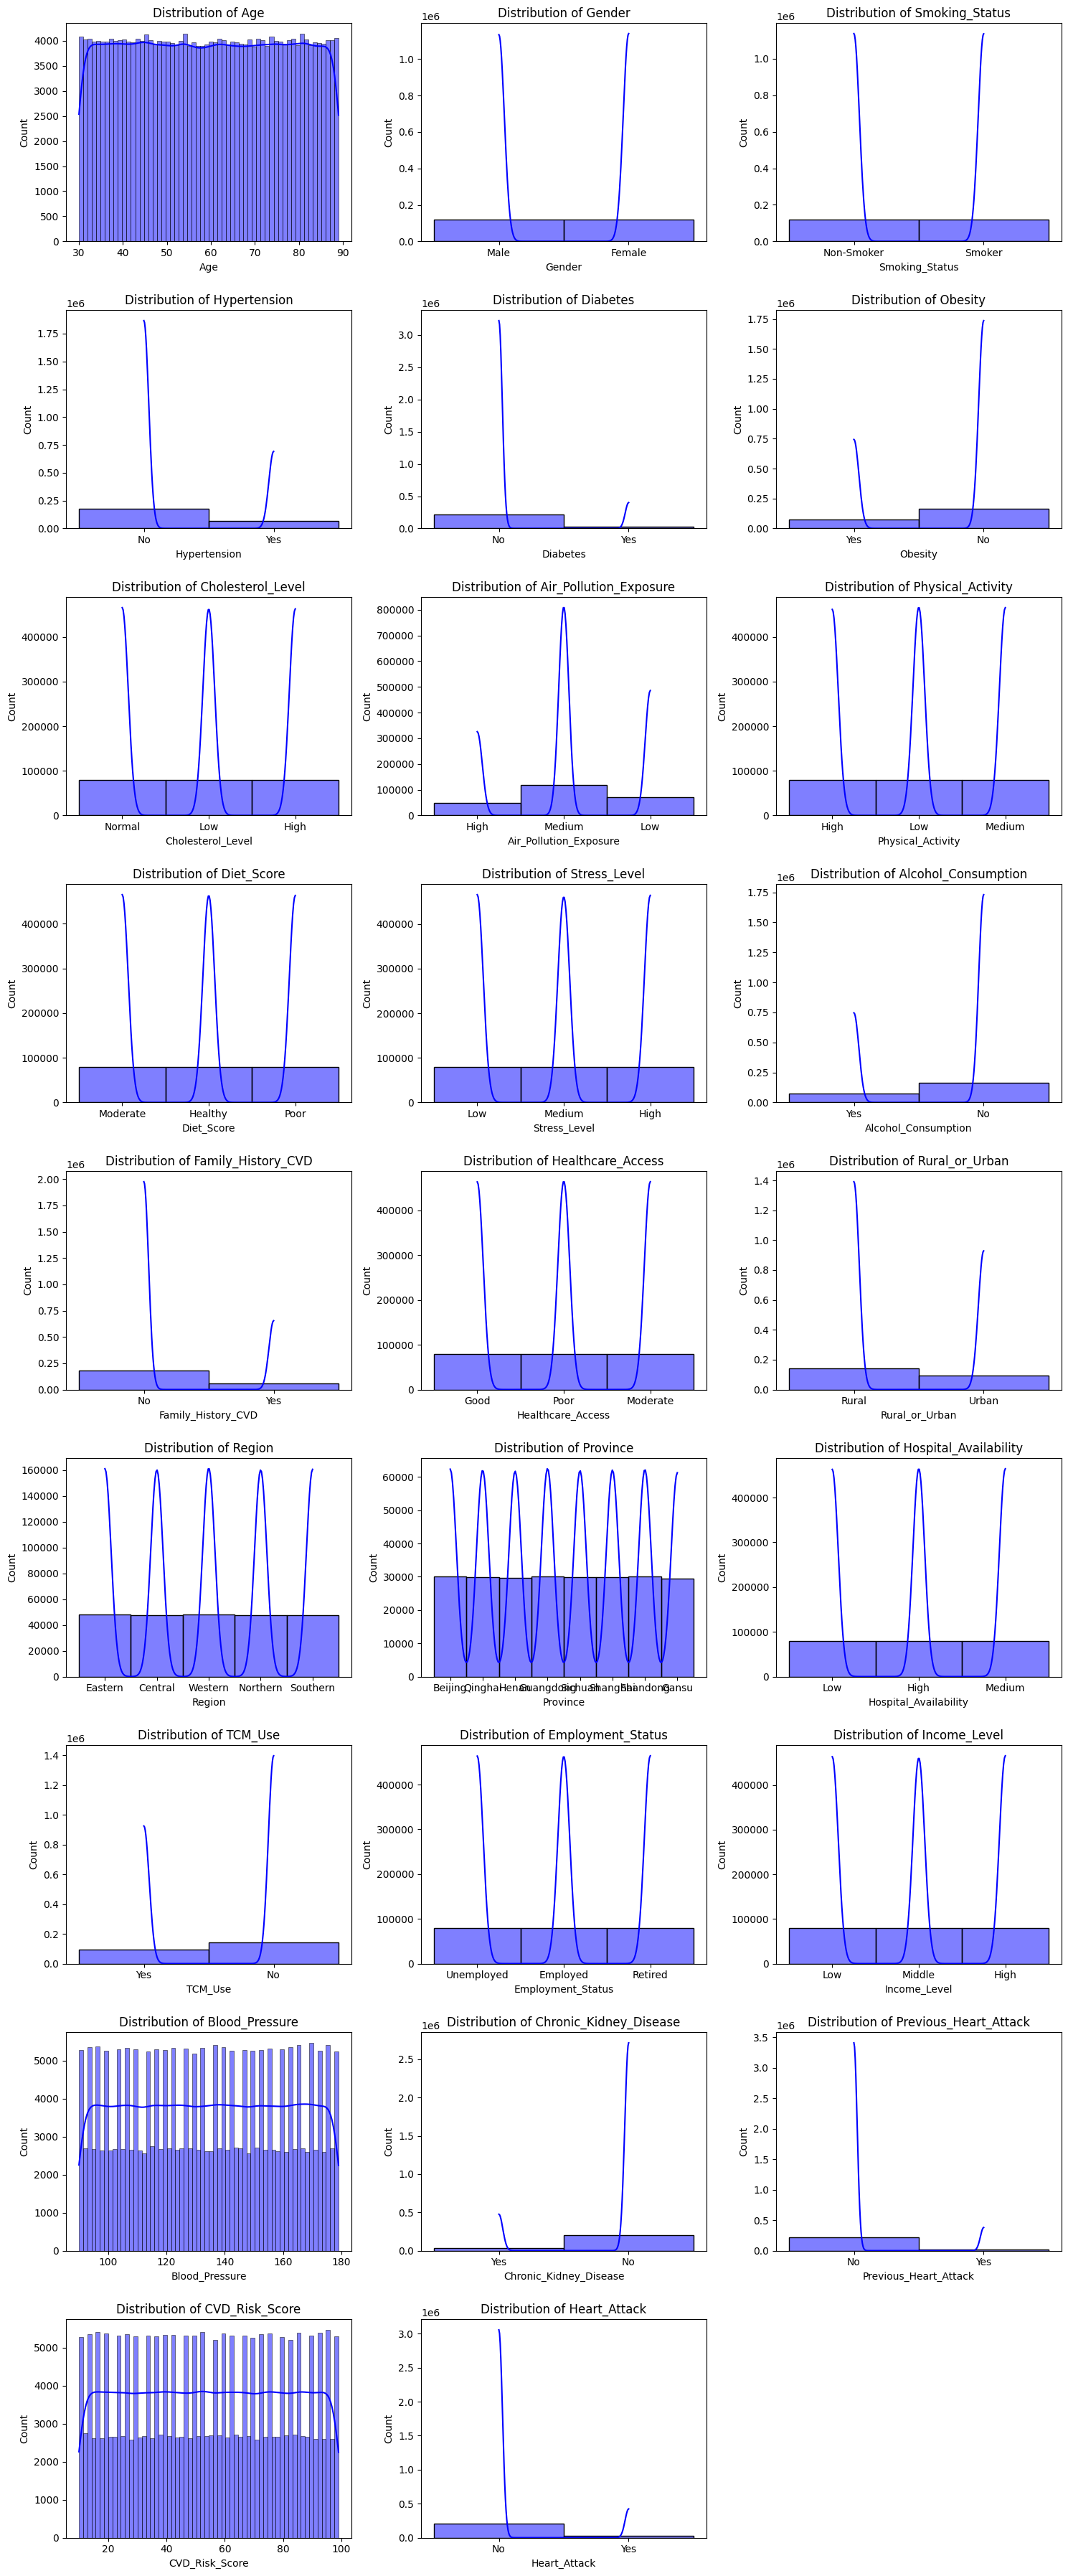

In [67]:
plot_dists(df, df.columns)

In [181]:
feat_select(df_encoded, 'heart_attack_yes', method='elastic_net')

Best alpha: 1.0
Best l1_ratio: 0.1

Feature Coefficients:
age                             -0.0
blood_pressure                   0.0
cvd_risk_score                  -0.0
gender_male                     -0.0
smoking_status_smoker           -0.0
hypertension_yes                 0.0
diabetes_yes                     0.0
obesity_yes                      0.0
cholesterol_level_low           -0.0
cholesterol_level_normal         0.0
air_pollution_exposure_low      -0.0
air_pollution_exposure_medium    0.0
physical_activity_low            0.0
physical_activity_medium        -0.0
diet_score_moderate              0.0
diet_score_poor                  0.0
stress_level_low                 0.0
stress_level_medium              0.0
alcohol_consumption_yes          0.0
family_history_cvd_yes          -0.0
healthcare_access_moderate      -0.0
healthcare_access_poor           0.0
rural_or_urban_urban             0.0
region_eastern                   0.0
region_northern                 -0.0
region_southern  

,heart_attack_yes
0,0
1,0
2,0
3,0
4,0
...,...
239261,1
239262,0
239263,0
239264,1


In [186]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=10)
X_resam, y_resam = smote.fit_resample(X_scaled, y)

Selected Features: ['age', 'blood_pressure', 'cvd_risk_score', 'gender_male', 'hypertension_yes', 'diabetes_yes', 'obesity_yes', 'cholesterol_level_low', 'cholesterol_level_normal', 'air_pollution_exposure_medium', 'physical_activity_low', 'physical_activity_medium', 'diet_score_moderate', 'diet_score_poor', 'stress_level_low', 'stress_level_medium', 'alcohol_consumption_yes', 'family_history_cvd_yes', 'healthcare_access_moderate', 'healthcare_access_poor', 'rural_or_urban_urban', 'region_eastern', 'region_northern', 'region_southern', 'region_western', 'province_gansu', 'province_guangdong', 'province_henan', 'province_qinghai', 'province_shandong', 'province_shanghai', 'province_sichuan', 'hospital_availability_low', 'hospital_availability_medium', 'tcm_use_yes', 'employment_status_retired', 'employment_status_unemployed', 'income_level_low', 'income_level_middle', 'chronic_kidney_disease_yes', 'previous_heart_attack_yes']


In [180]:
from sklearn.linear_model import Lasso, Ridge, ElasticNetCV

model = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000)
model.fit(X_scaled, y)
selected_feats = X.columns[model.coef_ != 0].to_list()
print(f"Selected Features: {selected_feats}")



Selected Features: ['cvd_risk_score', 'obesity_yes', 'cholesterol_level_low', 'physical_activity_medium', 'diet_score_poor', 'stress_level_low', 'rural_or_urban_urban', 'region_northern', 'province_gansu', 'province_guangdong', 'province_henan', 'hospital_availability_medium', 'employment_status_retired', 'employment_status_unemployed', 'income_level_middle']


In [184]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

elastic_model = ElasticNetCV(alphas=np.logspace(-6, -2, 50), l1_ratio=[0.1, 0.3, 0.5, 0.9], cv=cv, random_state=10)
elastic_model.fit(X_scaled, y) 
selected_feats = X.columns[elastic_model.coef_ != 0].to_list()
print(f"Selected Features: {selected_feats}")

print(f"Best alpha: {elastic_model.alpha_}")
print(f"Best l1_ratio: {elastic_model.l1_ratio_}")

Selected Features: []
Best alpha: 0.01
Best l1_ratio: 0.3


In [191]:
elastic_model.fit(X_resam, y_resam)

selected_feats = X.columns[elastic_model.coef_ != 0].to_list()
print(f"Selected Features: {selected_feats}")

len(selected_feats)

Selected Features: ['age', 'blood_pressure', 'cvd_risk_score', 'gender_male', 'hypertension_yes', 'diabetes_yes', 'obesity_yes', 'cholesterol_level_low', 'cholesterol_level_normal', 'air_pollution_exposure_medium', 'physical_activity_low', 'physical_activity_medium', 'diet_score_moderate', 'diet_score_poor', 'stress_level_low', 'stress_level_medium', 'alcohol_consumption_yes', 'family_history_cvd_yes', 'healthcare_access_moderate', 'healthcare_access_poor', 'rural_or_urban_urban', 'region_eastern', 'region_northern', 'region_southern', 'region_western', 'province_gansu', 'province_guangdong', 'province_henan', 'province_qinghai', 'province_shandong', 'province_shanghai', 'province_sichuan', 'hospital_availability_low', 'hospital_availability_medium', 'tcm_use_yes', 'employment_status_retired', 'employment_status_unemployed', 'income_level_low', 'income_level_middle', 'chronic_kidney_disease_yes', 'previous_heart_attack_yes']


41

In [ ]:
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import StratifiedKFold

def feat_select(df: pd.DataFrame, target:str, imbalance_thresh=0.15, smote_enabled=True):
    '''
    - Performs automatic feature selection using Elastic Net regression (but searches params that qualify as full lasso or full ridge)
    - Handles class imbalance via SMOTE (if it exists)

    Args: 
        df (DataFrame): dataset that has already been OHE
        target (str): name of target column
        imbalance _thresh: if minority class is below this threshold, apply SMOTE

    Returns: 
        - selected_feats: list of selected feature names
        - best_alpha: best alpha value chosen by ElasticNetCV
    '''

    # Check for imbalanced target class
    class_counts = np.bincount(df[target])
    min_class_ratio = class_counts.min() / class_counts.sum()

    if min_class_ratio < imbalance_thresh and smote_enabled:
        print(f'⚠️ Imbalanced data detected \n(Minority class = {min_class_ratio:.2%}) \nApplying SMOTE...\n')
        smote = SMOTE(random_state=10)
        X, y = smote.fit_resample(df, df[target])
    else: 
        X, y = df, df[target]

    original_feat_count = X.shape[1]

    # Scaling the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  

    # ElasticNetCV Regularization
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10) 
    elastic_model = ElasticNetCV(
        alphas = np.logspace(-6, -2, 50), 
        l1_ratio=[0.1, 0.5, 0.9],
        cv = cv, 
        random_state=10
    )
    elastic_model.fit(X_scaled, y) 

    # Finally, feature selection!
    selected_feats = X.columns[elastic_model.coef_ != 0].to_list()
    selected_feat_count = len(selected_feats)

    if elastic_model.l1_ratio_ > 0.5:
        l1_message = "(closer to  lasso)"
    elif elastic_model.l1_ratio_ < 0.5:
        l1_message = "(closer to ridge)"

    print("ElasticNet Feature Selection Summary")
    print("=====================================")
    print(f"Original feature count: {original_feat_count}")
    print(f"🎯 Selected feature count: {selected_feat_count} (🔻{original_feat_count - selected_feat_count} trimmed)")
    print(f"Best Alpha: {elastic_model.alpha_:.2e}")
    print(f"Best L1 Ratio: {elastic_model.l1_ratio_:.2f} {l1_message}")
    print(f"Final Selected Features:")

    return selected_feats

In [217]:
feat_select(df_encoded, 'heart_attack_yes', smote_enabled=False)

ElasticNet Feature Selection Summary
Original feature count: 44
🎯 Selected feature count: 41 (🔻3 trimmed)
Best Alpha: 1.00e-06
Best L1 Ratio: 0.10, (closer to ridge)
Final Selected Features:


['age',
 'blood_pressure',
 'cvd_risk_score',
 'smoking_status_smoker',
 'diabetes_yes',
 'obesity_yes',
 'cholesterol_level_low',
 'cholesterol_level_normal',
 'air_pollution_exposure_low',
 'air_pollution_exposure_medium',
 'physical_activity_low',
 'physical_activity_medium',
 'diet_score_moderate',
 'diet_score_poor',
 'stress_level_low',
 'stress_level_medium',
 'alcohol_consumption_yes',
 'family_history_cvd_yes',
 'healthcare_access_moderate',
 'healthcare_access_poor',
 'rural_or_urban_urban',
 'region_eastern',
 'region_northern',
 'region_southern',
 'region_western',
 'province_gansu',
 'province_guangdong',
 'province_henan',
 'province_qinghai',
 'province_shandong',
 'province_shanghai',
 'province_sichuan',
 'hospital_availability_low',
 'hospital_availability_medium',
 'employment_status_retired',
 'employment_status_unemployed',
 'income_level_low',
 'income_level_middle',
 'chronic_kidney_disease_yes',
 'previous_heart_attack_yes',
 'heart_attack_yes']